# Telecom Churn Case Study

To dos

- [ ] derived features: create mean of 6+7 columns and substract month 8
- [x] train random forest first without PCA (more general model, less biased) to find feature importance
- [ ] use the resulting top features to train logistic regression (for explainable model)
- [ ] rfe/p/vif will probably be better, but takes longer
- [ ] try stacking if time
- [ ] can also try ridge/lasso
- [ ] DO NOT drop recharge colunmns (should be imputed with 0)
- [ ] class imbalances: Class_weights, about 10% in the data
https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18  
- [ ] MUST USE class_weight as hyperparameter: lr = LogisticRegression(class_weight='balanced')

Maybe:
- up sampling: copy existing data, again, and again
- down sampling: copy data and randomly select data
- data augmentation: randomly create data points around an existing data point, generally for positive cases, used to handle class imbalances/balance the ratio and overfitting
- SMOTE: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 

# 1. Data understanding

The first part of this Case Study is Data Understanding, in which we explore the dataframe and study the datatypes, the statistics (for e.g., mean, 25th percentile, 75th percentile) and the number of missing values of the dataframe.

In [1]:
#importing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import warnings #turning off warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
#from imblearn.over_sampling import SMOTE 
#from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipeline
#from sklearn.linear_model import Ridge
#from sklearn.metrics import mean_squared_error, r2_score

#printing the versions of libraries to be used in this notebook
from platform import python_version
print("Library versions used in this project:")
print("-------------------------")
print("python: ",python_version())
print("numpy: ",np.__version__) #numpy version
print("pandas: ",pd.__version__) #pandas version
print("matplotlib: ",matplotlib.__version__) #matplotlib version
print("seaborn: ",sns.__version__)
print("sklearn: ",sklearn.__version__)

Library versions used in this project:
-------------------------
python:  3.8.8
numpy:  1.19.5
pandas:  1.4.1
matplotlib:  3.5.0
seaborn:  0.11.2
sklearn:  1.0.2


In [2]:
#import os
#os.listdir('../input/telecom-churn-case-study-hackathon-gc2')

# read training data
#df = pd.read_csv('../input/telecom-churn-case-study-hackathon-gc2/train (1).csv')
df = pd.read_csv('train (1).csv')
df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [3]:
# display basic info
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [4]:
pd.set_option('display.max_columns', 500)
df.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

## 1.1. Data cleaning

Here, I decided to examine the values in the dataframe.

In [5]:
# display missing data per column and data type
df_na_cols = df.columns[df.isna().any()].tolist()

#displaying number of missing values and the percentage of missing values
for col in df_na_cols:
    na_perc = df[col].isna().sum()/df[col].shape[0]
    print("column name: {}, number of NAs: {}, percentage of NAs: {}%".format(col, df[col].isna().sum(), np.round(na_perc,2) * 100, df[col].dtypes))

column name: loc_og_t2o_mou, number of NAs: 702, percentage of NAs: 1.0%
column name: std_og_t2o_mou, number of NAs: 702, percentage of NAs: 1.0%
column name: loc_ic_t2o_mou, number of NAs: 702, percentage of NAs: 1.0%
column name: last_date_of_month_7, number of NAs: 399, percentage of NAs: 1.0%
column name: last_date_of_month_8, number of NAs: 733, percentage of NAs: 1.0%
column name: onnet_mou_6, number of NAs: 2768, percentage of NAs: 4.0%
column name: onnet_mou_7, number of NAs: 2687, percentage of NAs: 4.0%
column name: onnet_mou_8, number of NAs: 3703, percentage of NAs: 5.0%
column name: offnet_mou_6, number of NAs: 2768, percentage of NAs: 4.0%
column name: offnet_mou_7, number of NAs: 2687, percentage of NAs: 4.0%
column name: offnet_mou_8, number of NAs: 3703, percentage of NAs: 5.0%
column name: roam_ic_mou_6, number of NAs: 2768, percentage of NAs: 4.0%
column name: roam_ic_mou_7, number of NAs: 2687, percentage of NAs: 4.0%
column name: roam_ic_mou_8, number of NAs: 3703,

It is notable that there are some columns that have a high value of no data imputed. With some columns as high as 70% or more. However, this does not indicate that the variables are not going to be important for the model. The data might indicate that the customer churned in one of the three months that data is available for. As a result, no data would be collected in subsequent months for this customer. As a result, decisions for dropping columns were not based on missing data; specifics will be discussed throughout the notebook.

Text(0.5, 1.0, 'Churn Rate')

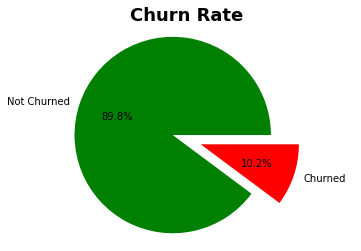

In [6]:
# count data instances of churn probability
df.groupby('churn_probability').count()['id'].plot.pie(labels=['Not Churned','Churned'],autopct='%1.1f%%',colors=['green', 'red'],explode=(.3,0),label="")
plt.axis('equal')
plt.title('Churn Rate',fontsize=18,fontweight='bold')

The above reveals that there is a class imbalance issue, in which only around 10% of the users churned, while close to 90% of the users did not churn. While this is generally desirable from a business perspective, it can cause issues in the derived model, resulting potentially in a  high-accuracy low-recall model 

## 1.2 Categorical variables
I now observe the categorical variables which I believe that are useful to the analysis.
1. fb_user: likely to be related to some Facebook campaign
2. night_pck_user: likely to be related to some night package campaigns by the telco company.

Here, it is important to note that the data is from 2014, hence business insights will take into consideration the type of data that was of relevance to the company then, even though the actual model is build in 2022. 
Video and audio content om mobile devices accounted for about just under 40% in 2014 and was predicted to double over the next four years until 2018.

As McKinsey Consulting put it in 2016: "Telecom companies face increasingly tough times as digitization reshapes the industry landscape. In fact, telecoms come second only to media in the ranks of sectors expecting moderate or massive digital disruption over the next 12 months, according to a 2015 cross-industry survey of senior industry leaders."

In 2014, it was noted that three out of every four people online use social media. For telecom service providers and other companies, that usage makes the business case for spending money to engage customers via social media. However, unlimited data plans had not become the norm yet, hence social media users (`fb_user`) and users outside of peak hours (`night_pck_users`) provided relevant information for telecommunication companies. Often, mobile phone plans and associated "packages" were highly confusing for the customer and specific for the company (to such an astounding degree that a study by policy institute New America decided to completely omit smar phone mobile data usage from their yearly studies). At the time, some companies started to experiment with offering access to social media sites without counting the usage towards the user's data limit: 

"The deal sounds great: Stream unlimited music without any data charges. The offer from T-Mobile includes popular services such as Spotify, iTunes, and Pandora. These apps will no longer count against your data plan, the company announced recently, no matter how much you stream across its 4G LTE network." 

Yet, in 2014, a considerable amount of users were still dealing with "data allowances" that had an impact on customers' usage of the internet. It was estimated that logging into FaceBook consumed 3MB of data. Hence, providing customers with enticing offers to use the internet without - or at least with fewer - restrictions, would have been an important business decision for telecommunication companies of the time. 

(sources:
https://www2.deloitte.com/content/dam/Deloitte/in/Documents/technology-media-telecommunications/in-tmt-rise-of-on-demand-content.pdf
https://www.mckinsey.com/business-functions/mckinsey-digital/our-insights/how-telecom-companies-can-win-in-the-digital-revolution
https://inform.tmforum.org/features-and-analysis/2014/06/social-media-strategy-hitting-mark/
https://www.wired.com/2014/08/free-mobile-data-plans-are-going-to-crush-the-startup-economy/
https://www.newamerica.org/oti/policy-papers/the-cost-of-connectivity-2014/
https://kenstechtips.com/index.php/mobile-internet-study-how-many-gigabytes)

In [7]:
# converting columns of incorrect data type from float to int
df.loc[:,['fb_user_6', 'fb_user_7', 'fb_user_8']] =  df.loc[:,['fb_user_6', 'fb_user_7', 'fb_user_8']].fillna(0).astype(int)
df.loc[:,['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']] =  df.loc[:,['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']].fillna(0).astype(int)

As a result of the discussion above, missing values have been imputed with 0 in the categorical variables above.

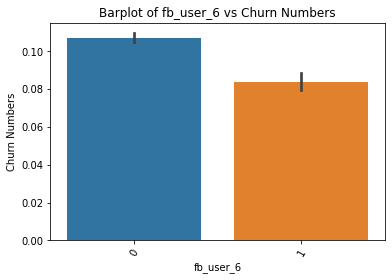

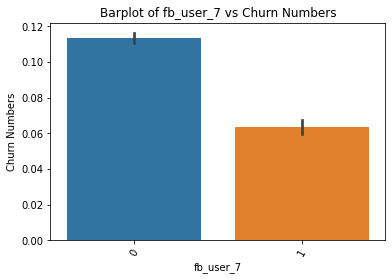

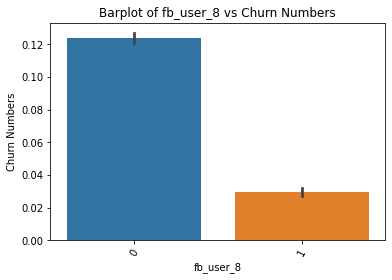

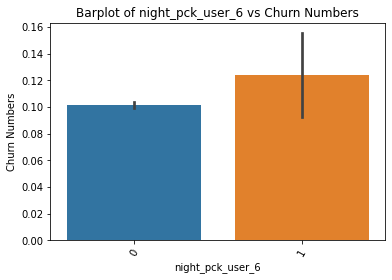

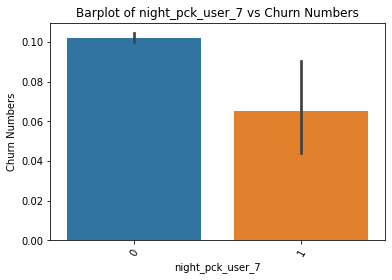

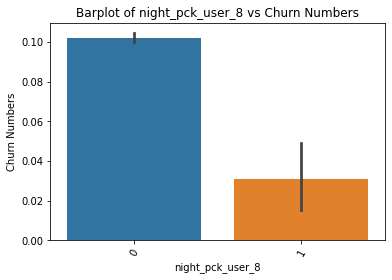

In [8]:
# visualizing categorical variables
categorical_vars = ['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']

for col in categorical_vars:
    ax = sns.barplot(x=col, y='churn_probability', data=df)
    plt.xlabel(col)
    plt.xticks(rotation = 60)
    plt.ylabel("Churn Numbers")
    plt.title("Barplot of {} vs Churn Numbers".format(col))
    plt.show()

## 1.2 Continuous variables

In this analysis, I have decided to define 'high-value' customers as customers who have higher usage of the various services offered by the teleco (whether it is roaming, calls within network etc.), and high-value customers would continue to use the services across June, July and August 2014.

However, customers who are likely to churn would see a decrease in the usage, in other words, they used a lot the services a lot in June and July, before drastially dropping off in August.

Therefore, my formula would be depicted as follows:

### Delta = Mean (June and July) - August

In [9]:
#swap two particular columns which are out of order and not in sync with the above formula
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

df = swap_columns(df, 'aug_vbc_3g', 'jun_vbc_3g')

In [10]:
# create list of numeric data only
'''
numeric_cols = []
for col in df.loc[:,'arpu_6':'jun_vbc_3g'].columns:
    if col !='aon' and df[col].dtype == 'float64':
        numeric_cols.append(col)

for i in range(0, len(numeric_cols),3):
    new_name = numeric_cols[i][:-1] + 'sum'
    print("new variable {}".format(new_name))
    print("made up of variables : {}, {}, {}".format(numeric_cols[i], numeric_cols[i+1], numeric_cols[i+2]))
    temp = df[[numeric_cols[i], numeric_cols[i+1], numeric_cols[i+2]]]
    df.loc[:, new_name] = temp.sum(axis=1)'''



numeric_cols = []
for col in df.loc[:,'arpu_6':'aug_vbc_3g'].columns:
    if col !='aon' and df[col].dtype == 'float64':
        numeric_cols.append(col)

for i in range(0, len(numeric_cols),3):
    new_name = numeric_cols[i][:-1] + 'diff'
    print("new variable {}".format(new_name))
    print("made up of variables : {}, {}, {}".format(numeric_cols[i], numeric_cols[i+1], numeric_cols[i+2]))
    df.loc[:, new_name] = df[[numeric_cols[i], numeric_cols[i+1]]].mean(axis=1) - df[numeric_cols[i+2]]

new variable arpu_diff
made up of variables : arpu_6, arpu_7, arpu_8
new variable onnet_mou_diff
made up of variables : onnet_mou_6, onnet_mou_7, onnet_mou_8
new variable offnet_mou_diff
made up of variables : offnet_mou_6, offnet_mou_7, offnet_mou_8
new variable roam_ic_mou_diff
made up of variables : roam_ic_mou_6, roam_ic_mou_7, roam_ic_mou_8
new variable roam_og_mou_diff
made up of variables : roam_og_mou_6, roam_og_mou_7, roam_og_mou_8
new variable loc_og_t2t_mou_diff
made up of variables : loc_og_t2t_mou_6, loc_og_t2t_mou_7, loc_og_t2t_mou_8
new variable loc_og_t2m_mou_diff
made up of variables : loc_og_t2m_mou_6, loc_og_t2m_mou_7, loc_og_t2m_mou_8
new variable loc_og_t2f_mou_diff
made up of variables : loc_og_t2f_mou_6, loc_og_t2f_mou_7, loc_og_t2f_mou_8
new variable loc_og_t2c_mou_diff
made up of variables : loc_og_t2c_mou_6, loc_og_t2c_mou_7, loc_og_t2c_mou_8
new variable loc_og_mou_diff
made up of variables : loc_og_mou_6, loc_og_mou_7, loc_og_mou_8
new variable std_og_t2t_mo

In [11]:
# finalised numeric data
final_numeric_cols = []
for col in df.columns:
    if col[-4:] == 'diff':
        final_numeric_cols.append(col)

# adding 'aon' column
final_numeric_cols += ['aon']
df[final_numeric_cols].describe()

,arpu_diff,onnet_mou_diff,offnet_mou_diff,roam_ic_mou_diff,roam_og_mou_diff,loc_og_t2t_mou_diff,loc_og_t2m_mou_diff,loc_og_t2f_mou_diff,loc_og_t2c_mou_diff,loc_og_mou_diff,std_og_t2t_mou_diff,std_og_t2m_mou_diff,std_og_t2f_mou_diff,std_og_t2c_mou_diff,std_og_mou_diff,isd_og_mou_diff,spl_og_mou_diff,og_others_diff,total_og_mou_diff,loc_ic_t2t_mou_diff,loc_ic_t2m_mou_diff,loc_ic_t2f_mou_diff,loc_ic_mou_diff,std_ic_t2t_mou_diff,std_ic_t2m_mou_diff,std_ic_t2f_mou_diff,std_ic_t2o_mou_diff,std_ic_mou_diff,total_ic_mou_diff,spl_ic_mou_diff,isd_ic_mou_diff,ic_others_diff,total_rech_data_diff,max_rech_data_diff,count_rech_2g_diff,count_rech_3g_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff,arpu_3g_diff,arpu_2g_diff,jun_vbc_3diff,aon
count,69999.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.0,65807.000000,65807.000000,65807.000000,65807.000000,69999.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.000000,65807.0,65807.000000,69999.000000,65807.000000,65807.000000,65807.000000,14749.000000,14749.000000,14749.000000,14749.000000,14749.000000,69999.000000,69999.000000,14749.000000,14749.000000,69999.000000,69999.000000
mean,1.801312,0.283832,1.197842,1.275511,2.110022,0.939112,0.933680,0.121679,-0.165393,1.994542,-1.548599,-1.012427,0.049978,0.0,-2.510966,-0.026446,-0.579143,0.201820,3.998990,0.586351,-1.401329,0.593228,-0.221819,-0.234877,0.105795,0.099769,0.0,-0.029341,2.308301,0.007209,-0.642677,-0.022529,-0.103939,-2.703777,-0.058546,-0.045393,-5.266017,1.379558,-9.933378,-3.093913,-1.637036,-5.102312,1220.639709
std,231.859069,207.990856,231.659511,46.927089,58.742759,93.532275,95.507276,8.301973,6.224671,141.821560,182.324276,200.484605,5.598772,0.0,288.087663,7.971119,16.053528,3.461577,344.528832,86.107563,106.283744,24.876341,145.061165,43.862261,60.000960,10.877240,0.0,77.041953,182.154256,0.180740,47.332953,10.428969,2.550615,68.641759,2.161066,1.212877,160.380578,176.701964,391.591578,141.443341,128.946301,201.894552,952.426321
min,-12808.617000,-6359.920000,-12604.240000,-2277.980000,-3057.150000,-6412.690000,-2262.120000,-452.720000,-213.230000,-4619.975000,-4806.465000,-12685.460000,-209.935000,0.0,-12715.480000,-544.780000,-747.620000,-366.590000,-12768.705000,-3743.340000,-4940.150000,-1039.310000,-4940.125000,-3313.875000,-2528.410000,-565.780000,0.0,-3405.025000,-6654.600000,-16.550000,-3163.690000,-774.130000,-41.000000,-1352.000000,-26.500000,-42.500000,-1805.000000,-8062.295000,-13887.680000,-3267.360000,-3027.375000,-8475.370000,180.000000
25%,-77.062000,-16.822500,-38.160000,0.000000,0.000000,-6.765000,-18.392500,0.000000,0.000000,-26.190000,-0.425000,-4.480000,0.000000,0.0,-10.095000,0.000000,-0.877500,0.000000,-58.297500,-8.240000,-23.400000,-0.970000,-32.740000,-0.080000,-2.470000,0.000000,0.0,-4.880000,-40.010000,0.000000,0.000000,0.000000,-1.000000,-6.000000,-0.500000,0.000000,-54.000000,0.000000,0.000000,-10.355000,-14.020000,0.000000,468.000000
50%,5.959500,0.785000,2.745000,0.000000,0.000000,0.230000,0.605000,0.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.715000,0.325000,0.260000,0.000000,0.665000,0.000000,0.000000,0.000000,0.0,0.100000,1.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000
75%,85.807250,21.777500,45.705000,0.000000,0.000000,8.820000,21.117500,0.640000,0.000000,30.420000,2.840000,8.052500,0.000000,0.0,14.247500,0.000000,1.205000,0.000000,71.575000,10.000000,23.470000,2.000000,34.410000,1.215000,4.342500,0.000000,0.0,7.155000,45.125000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,56.000000,0.000000,0.000000,15.285000,20.765000,0.000000,1813.000000
max,5811.052500,5295.315000,7094.390000,1539.130000,2410.835000,3276.375000,2863.535000,260.835000,384.385000,3270.400000,5391.21

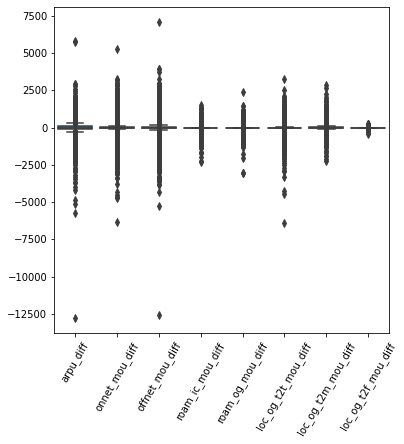

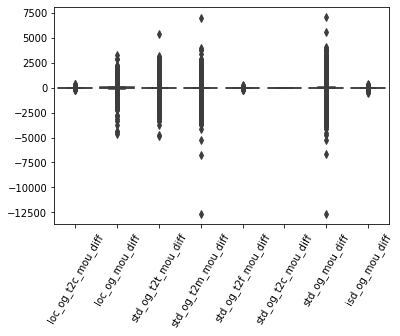

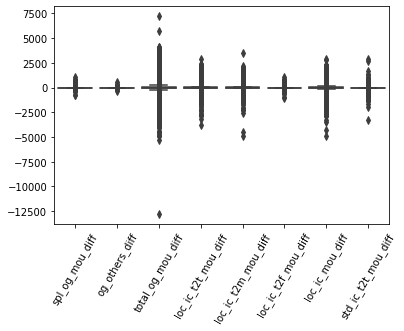

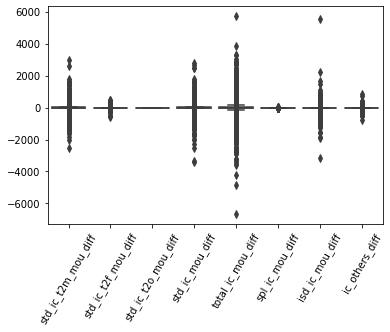

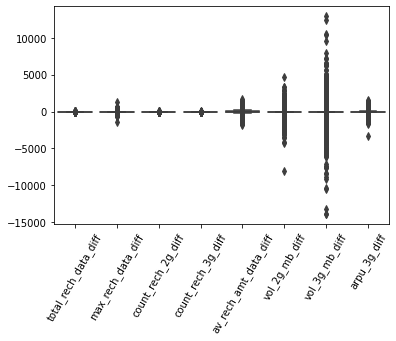

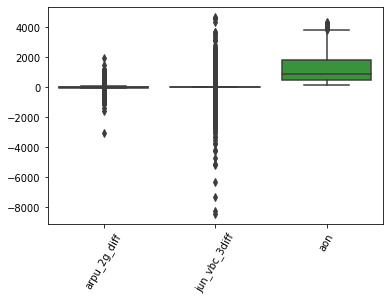

In [12]:
# display histograms
fig, ax = plt.subplots(figsize=(6, 6))

for idx in range(0,len(final_numeric_cols),8):
    selected_numeric_cols = final_numeric_cols[idx:idx+8]
    df_subset = df.loc[:,selected_numeric_cols]
    ax = sns.boxplot(data=df_subset)
    #plt.xlabel()
    plt.xticks(rotation = 60)
    plt.show()

Next

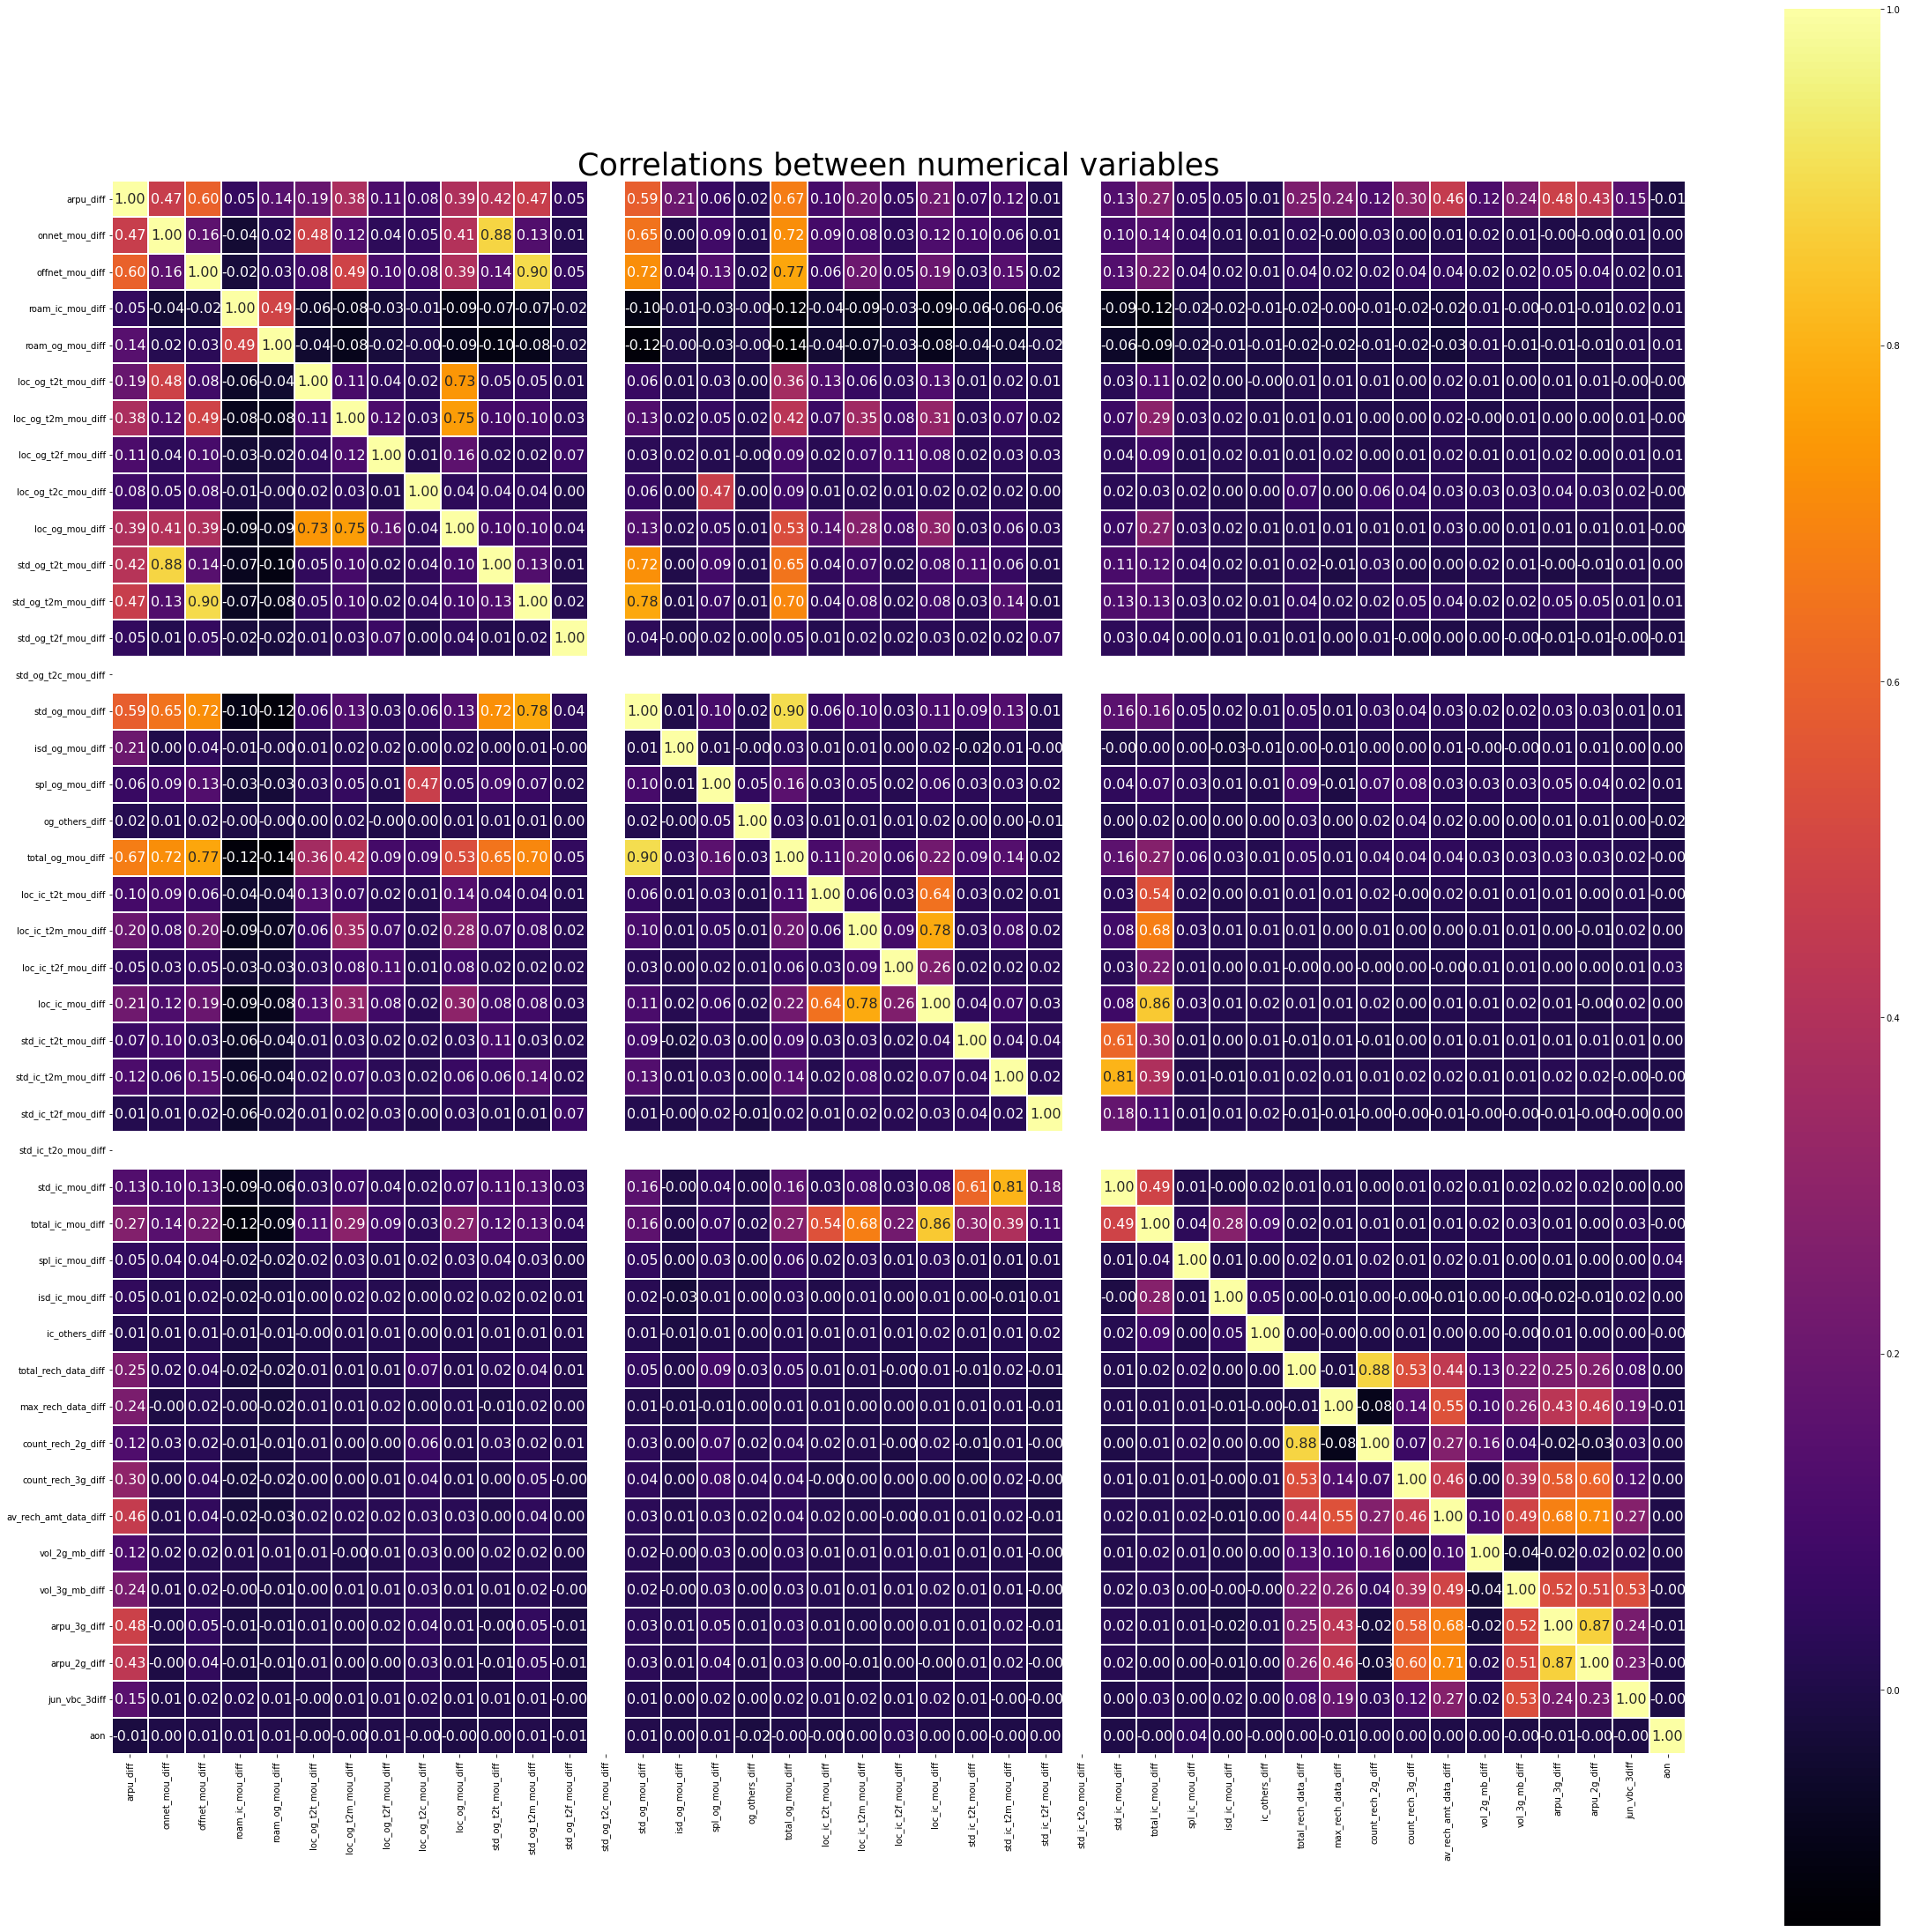

In [13]:
# correlation matrix between numerical variables
plt.figure(figsize = (40,40))        # Size of the figure

sns.heatmap(df[final_numeric_cols].corr(), annot = True, linewidths = 2, square= True, cmap= "inferno", fmt='.2f', annot_kws={'size':16}) 

plt.title('Correlations between numerical variables', fontsize=35)

plt.show()

In [14]:
# drop columns with all zeros
df[final_numeric_cols].sum(axis=0)== 0

empty_col = []
for col in df[final_numeric_cols].columns:
    if df[col].sum(axis=0) == 0:
        empty_col.append(col)
        
final_numeric_cols = [col for col in final_numeric_cols if col not in empty_col]
print(final_numeric_cols)

['arpu_diff', 'onnet_mou_diff', 'offnet_mou_diff', 'roam_ic_mou_diff', 'roam_og_mou_diff', 'loc_og_t2t_mou_diff', 'loc_og_t2m_mou_diff', 'loc_og_t2f_mou_diff', 'loc_og_t2c_mou_diff', 'loc_og_mou_diff', 'std_og_t2t_mou_diff', 'std_og_t2m_mou_diff', 'std_og_t2f_mou_diff', 'std_og_mou_diff', 'isd_og_mou_diff', 'spl_og_mou_diff', 'og_others_diff', 'total_og_mou_diff', 'loc_ic_t2t_mou_diff', 'loc_ic_t2m_mou_diff', 'loc_ic_t2f_mou_diff', 'loc_ic_mou_diff', 'std_ic_t2t_mou_diff', 'std_ic_t2m_mou_diff', 'std_ic_t2f_mou_diff', 'std_ic_mou_diff', 'total_ic_mou_diff', 'spl_ic_mou_diff', 'isd_ic_mou_diff', 'ic_others_diff', 'total_rech_data_diff', 'max_rech_data_diff', 'count_rech_2g_diff', 'count_rech_3g_diff', 'av_rech_amt_data_diff', 'vol_2g_mb_diff', 'vol_3g_mb_diff', 'arpu_3g_diff', 'arpu_2g_diff', 'jun_vbc_3diff', 'aon']


Due to the lack of variance in the columns above, columns with only one value were removed before model building. 

# 2. Model Building
## 2.1 Creating first base model using Random Forest

Random Forest was first selected due to the large number of variables. My objective was to use Random Forest and to use Grid Search in order to find the most important features.

The most important features would then be fed into the Logistics Regression model to create an explainable model.

In [15]:
scaler = StandardScaler()

df.loc[:, final_numeric_cols] = df.loc[:, final_numeric_cols].fillna(0)
df.loc[:, final_numeric_cols] = scaler.fit_transform(df.loc[:, final_numeric_cols])
y = df['churn_probability'].values

In [16]:
# removing June data as I do not think that they are important features from the prior EDA. 
#categorical_vars = ['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']
final_selected_features = final_numeric_cols +  ['fb_user_7', 'fb_user_8', 
                                                 'night_pck_user_7', 'night_pck_user_8']
X = df.loc[:, final_selected_features]

In [17]:
# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)
X_train.shape, X_test.shape

((48999, 45), (21000, 45))

In [18]:
# initiate random forest
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)

In [19]:
# fit model onto the data
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)

In [20]:
# predict on train and test set
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [21]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     18860
           1       0.84      0.33      0.48      2140

    accuracy                           0.93     21000
   macro avg       0.89      0.66      0.72     21000
weighted avg       0.92      0.93      0.91     21000



While the model achieves an accuracy of 91%, it is very noticeable that the recall score for the minority class is very low.

In [22]:
def evaluate_model(classifier, X_train, X_test, y_train, y_test):
    print("Train Accuracy :", accuracy_score(y_train, classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, classifier.predict(X_test)))

In [23]:
evaluate_model(rf, X_train, X_test, y_train, y_test)

Train Accuracy : 0.9269576930141431
Train Confusion Matrix:
[[43690   317]
 [ 3262  1730]]
--------------------------------------------------
Test Accuracy : 0.9258571428571428
Test Confusion Matrix:
[[18728   132]
 [ 1425   715]]


## 2.2 Grid Search to find top features

Grid Search is performed here in order to find the best parameters.
The most imporant features as found by the Grid Search will then be later fitted into a Logistics Regression model.

In [24]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [25]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}

In [26]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [27]:
%%time
grid_search.fit(X_train,y_train)
# perform grid search

Fitting 4 folds for each of 375 candidates, totalling 1500 fits
CPU times: total: 27.7 s
Wall time: 11min 5s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [28]:
# set best estimator to a variable
rf_best = grid_search.best_estimator_

In [29]:
# display best estimators
rf_best

RandomForestClassifier(max_depth=20, max_features=3, min_samples_leaf=5,
                       random_state=42)

In [30]:
# show feature importance
rf_best.feature_importances_

evaluate_model(rf_best, X_train, X_test, y_train, y_test)

Train Accuracy : 0.9495499908161391
Train Confusion Matrix:
[[43590   417]
 [ 2055  2937]]
--------------------------------------------------
Test Accuracy : 0.9356666666666666
Test Confusion Matrix:
[[18644   216]
 [ 1135  1005]]


In [31]:
# create new data frame with the selected features and their found feature importance
rf_df = pd.DataFrame({
    "Varname": final_selected_features,
    "Imp": rf_best.feature_importances_
})

rf_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
19,loc_ic_t2m_mou_diff,0.081383
21,loc_ic_mou_diff,0.073922
0,arpu_diff,0.060811
6,loc_og_t2m_mou_diff,0.055914
9,loc_og_mou_diff,0.054361
18,loc_ic_t2t_mou_diff,0.050119
5,loc_og_t2t_mou_diff,0.048396
17,total_og_mou_diff,0.043266
2,offnet_mou_diff,0.042016
1,onnet_mou_diff,0.040128


## 2.3 Logistic Regression

As requested by the requirements of the Case Study, a second model, the Logistics Regression model, will be built in order to compare the results with the Random Forest model. A regression model has the added benefit that the results are more explainable.

In [32]:
# set best features from random forest to regression model
cols_selected_by_rf = rf_df[rf_df['Imp'] >= 0.02]['Varname'].index

#create a new logistic regression model
logreg = LogisticRegression(class_weight='balanced')
#fit the model to the training data
X_train_lr, X_test_lr = X_train.iloc[:, cols_selected_by_rf], X_test.iloc[:, cols_selected_by_rf]
logreg.fit(X_train_lr, y_train)

LogisticRegression(class_weight='balanced')

The logistic regression model is set to `class_weight='balanced' to automatically adjust weights inversely proportional to class frequencies in the input data

In [33]:
# predict on train and test set
y_train_pred_lr = logreg.predict(X_train_lr)
y_test_pred_lr = logreg.predict(X_test_lr)

print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89     18860
           1       0.29      0.60      0.39      2140

    accuracy                           0.81     21000
   macro avg       0.62      0.71      0.64     21000
weighted avg       0.88      0.81      0.84     21000



The model accuracy is now 81%. However, the recall score is more balanced utilising the balanced weight class.

In [34]:
evaluate_model(logreg, X_train_lr, X_test_lr, y_train, y_test)

Train Accuracy : 0.8088940590624298
Train Confusion Matrix:
[[36639  7368]
 [ 1996  2996]]
--------------------------------------------------
Test Accuracy : 0.808047619047619
Test Confusion Matrix:
[[15693  3167]
 [  864  1276]]


## 2.3 PCA

PCA is used to reduce dimensionality on the model previously constructed.

PCA is best used on continuous variables, and it works in our case since none of the categorical variables were selected by the Random Forest model.

In [35]:
pca = PCA(random_state=42)

pca.fit(X_train_lr) 

PCA(random_state=42)

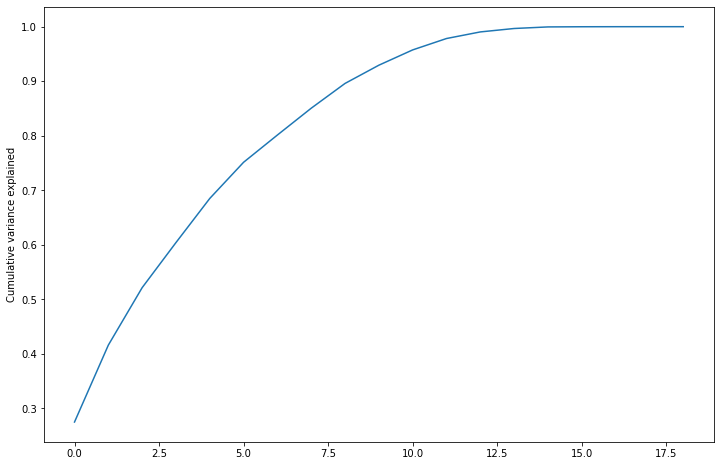

In [36]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=[12,8])
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [37]:
pca_final = IncrementalPCA(n_components=11) #from the graph above, I am selecting 11 components using Elbow Method

df_train_pca = pca_final.fit_transform(X_train_lr)

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca, y_train)

y_train_pred_lr = model_pca.predict(df_train_pca)

print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89     18860
           1       0.29      0.60      0.39      2140

    accuracy                           0.81     21000
   macro avg       0.62      0.71      0.64     21000
weighted avg       0.88      0.81      0.84     21000



In [38]:
df_test_pca = pca_final.transform(X_test_lr)

evaluate_model(learner_pca, df_train_pca, df_test_pca, y_train, y_test)

Train Accuracy : 0.8957937917100349
Train Confusion Matrix:
[[43761   246]
 [ 4860   132]]
--------------------------------------------------
Test Accuracy : 0.897
Test Confusion Matrix:
[[18775    85]
 [ 2078    62]]


The accuracy is now back up to 90%, with the same recall that the logistic regression model had. 

## 3.1 Pre-processing of test data

Actual test data will now be preprocessed according to the steps taken in the training and prediction phase.

In [39]:
# read in test data set
#test_set = pd.read_csv('../input/telecom-churn-case-study-hackathon-gc2/test (1).csv')
test_set = pd.read_csv('test (1).csv')

In [40]:
# converting columns of incorrect data type from float to int
test_set.loc[:,['fb_user_6', 'fb_user_7', 'fb_user_8']] =  test_set.loc[:,['fb_user_6', 'fb_user_7', 'fb_user_8']].fillna(0).astype(int)
test_set.loc[:,['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']] =  test_set.loc[:,['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']].fillna(0).astype(int)

In [41]:
#swap two particular columns which are out of order and not in sync with the above formula

test_set = swap_columns(test_set, 'aug_vbc_3g', 'jun_vbc_3g')

In [42]:
numeric_cols_test = []
for col in test_set.loc[:,'arpu_6':'aug_vbc_3g'].columns:
    if col !='aon' and test_set[col].dtype == 'float64':
        numeric_cols_test.append(col)

for i in range(0, len(numeric_cols_test),3):
    new_name = numeric_cols_test[i][:-1] + 'diff'
    print("new variable {}".format(new_name))
    print("made up of variables : {}, {}, {}".format(numeric_cols_test[i], numeric_cols_test[i+1], numeric_cols[i+2]))
    test_set.loc[:, new_name] = test_set[[numeric_cols_test[i], numeric_cols_test[i+1]]].mean(axis=1) - test_set[numeric_cols_test[i+2]]

new variable arpu_diff
made up of variables : arpu_6, arpu_7, arpu_8
new variable onnet_mou_diff
made up of variables : onnet_mou_6, onnet_mou_7, onnet_mou_8
new variable offnet_mou_diff
made up of variables : offnet_mou_6, offnet_mou_7, offnet_mou_8
new variable roam_ic_mou_diff
made up of variables : roam_ic_mou_6, roam_ic_mou_7, roam_ic_mou_8
new variable roam_og_mou_diff
made up of variables : roam_og_mou_6, roam_og_mou_7, roam_og_mou_8
new variable loc_og_t2t_mou_diff
made up of variables : loc_og_t2t_mou_6, loc_og_t2t_mou_7, loc_og_t2t_mou_8
new variable loc_og_t2m_mou_diff
made up of variables : loc_og_t2m_mou_6, loc_og_t2m_mou_7, loc_og_t2m_mou_8
new variable loc_og_t2f_mou_diff
made up of variables : loc_og_t2f_mou_6, loc_og_t2f_mou_7, loc_og_t2f_mou_8
new variable loc_og_t2c_mou_diff
made up of variables : loc_og_t2c_mou_6, loc_og_t2c_mou_7, loc_og_t2c_mou_8
new variable loc_og_mou_diff
made up of variables : loc_og_mou_6, loc_og_mou_7, loc_og_mou_8
new variable std_og_t2t_mo

In [45]:
#below are the features that were originally used for the first Random Forest model
test_set.loc[:, final_numeric_cols] = test_set.loc[:, final_numeric_cols].fillna(0)
test_set.loc[:, final_numeric_cols] = scaler.fit_transform(test_set.loc[:, final_numeric_cols])

#test_features = final_numeric_cols_test +  ['fb_user_7', 'fb_user_8', 'night_pck_user_7', 'night_pck_user_8']

In [46]:
#for RF model
X_test_final = test_set.loc[:,final_selected_features]
prediction_output = grid_search.predict(X_test_final)

#for Log Reg model

#features_after_rf = rf_df[rf_df['Imp'] >= 0.02]['Varname'] #we use the features selected by RF model but pass through Logistrics Regression model
#X_test_final = test_set.loc[:, features_after_rf]

#X_test_pca = pca_final.transform(X_test_final)
#prediction_output = model_pca.predict(X_test_pca)

## 3.2 Producing Submissions File

Generate the .csv file for submissions to Kaggle

In [47]:
submission_data = test_set['id']
print(submission_data.shape) #checking shape

prediction_output_df = pd.DataFrame(prediction_output).rename(columns = {0:'churn_probability'})
output = pd.concat([submission_data, prediction_output_df], axis=1)
11
pd.DataFrame(output).to_csv('submission.csv',index=False)

(30000,)


## Deleted algorithms

In [ ]:
# SMOTE
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('Count of instances churned/not churned:')
unique, counts = np.unique(y_sm, return_counts=True)

dict(zip(unique, counts))

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
# scaler = StandardScaler()
# pca = PCA(n_components=11)
# lr = LogisticRegression(max_iter=1000, tol=0.001)

In [ ]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scaler),
                         ('pca',pca_final),
                         ('model',logreg)])

In [ ]:
pipe.fit(X_train[test_features], y_train)

In [ ]:
train_score = pipe.score(X_train[test_features], y_train)
print("Training accuracy:", train_score)

In [ ]:
test_score = pipe.score(X_test[test_features], y_test)
print("Test accuracy:", test_score)

In [ ]:
confusion_matrix(y_train, pipe.predict(X_train[test_features]))

In [ ]:
confusion_matrix(y_test, pipe.predict(X_test[test_features]))

In [ ]:
precision_score(y_test, pipe.predict(X_test[test_features]))

In [ ]:
recall_score(y_test, pipe.predict(X_test[test_features]))

## 3.4 Submission file

Instructions:
Submission File Format:
You should submit a csv file with exactly 30,000 entries plus a header row. Your submission will show
an error if you have extra columns or rows.
The file should have exactly two columns:
● Id
● Churn probability (0 or 1)

In [ ]:
submission_data = test_set.set_index('id')[test_features]
submission_data.shape

In [ ]:
test_set['churn_probability'] = pipe.predict(submission_data)
output = test_set[['id','churn_probability']]
output.head()

In [ ]:
output.to_csv('submission.csv',index=False)

In [ ]:
# # write output to csv for submission
# submit_df = pd.DataFrame()
# submit_df['id'] = test_df['id]
# submit_df['churn_probability'] = predictions
# submit_df.to_csv('Submission.csv", index= False) # write submit_df with two columns in output folder.

## 

In [ ]:
#create voting classifier for ensemble
ensemble = VotingClassifier(estimators, voting='hard')

In [ ]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)